In [72]:
# import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.stats as stats

In [73]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

# CORREÇÃO 1: Adicione .copy() aqui para garantir que o Pandas crie um novo objeto
# limpo na memória, desconectado do original.
data = data[data['total sulfur dioxide'] < 200].copy()

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('residual sugar')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)


labels = data['residual sugar']
data2 = data.copy()
data.drop("residual sugar", axis=1, inplace=True)


data_tensor = torch.tensor(data.to_numpy(), dtype=torch.float32)
labels_tensor = torch.tensor(labels.to_numpy(), dtype=torch.float32)[:, None]

X_train, X_test, y_train, y_test = train_test_split(data_tensor, labels_tensor, test_size=.2)

datasetTrain = TensorDataset(X_train, y_train)
datasetTest = TensorDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(datasetTrain, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(datasetTest, batch_size=datasetTest.tensors[0].shape[0])

In [74]:
labels

0       1.9
1       2.6
2       2.3
3       1.9
4       1.9
       ... 
1594    2.0
1595    2.2
1596    2.3
1597    2.0
1598    3.6
Name: residual sugar, Length: 1597, dtype: float64

In [75]:
class ann(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input = nn.Linear(11,16)
        
        self.bnorm1 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(16,32)
        
        self.bnorm2 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32,20)
        
        self.output = nn.Linear(20,1)
        
    def forward(self, x):
        
        x = F.relu(self.input(x))

        x = self.bnorm1(x)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.bnorm2(x)
        x = self.fc2(x)
        x = F.relu(x)
            
        return self.output(x)
    

def trainModel(ann, lossfun, optimizer):
    lossesTest = []
    lossesTrain = []
    
    for epoch in range(1000):
        batchLoss = []
        ann.train()
        for X,y in train_loader:
            y_pred = ann(X)
            
            loss = lossfun(y_pred,y)
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            
            
        lossesTrain.append(np.mean(batchLoss))
        
        ann.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            y_pred = ann(X)
            
        loss = lossfun(y_pred, y)
        lossesTest.append(loss)
        
    return np.array(lossesTrain), np.array(lossesTest)
            

In [76]:
net = ann()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
lossfun = nn.MSELoss()

train, test = trainModel(net, lossfun, optimizer)

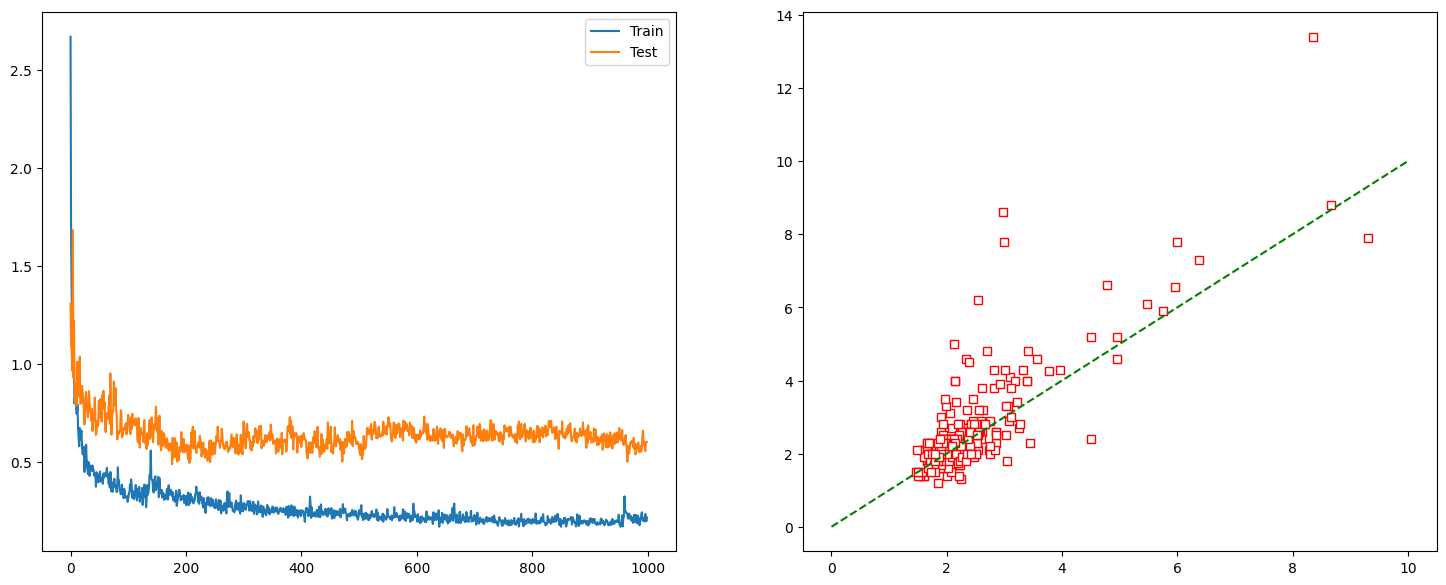

In [85]:
fig, ax = plt.subplots(1,2,figsize=(18,7))
ax[0].plot(train.T)
ax[0].plot(test.T)
ax[0].legend(["Train", "Test"])

X,y = next(iter(test_loader))
net.eval()
y_pred = net(X)
        
ax[1].plot(y_pred.detach(), y.detach(), "sr", markerfacecolor="w")
ax[1].plot(np.linspace(0,10,9), np.linspace(0,10,9), "g--")

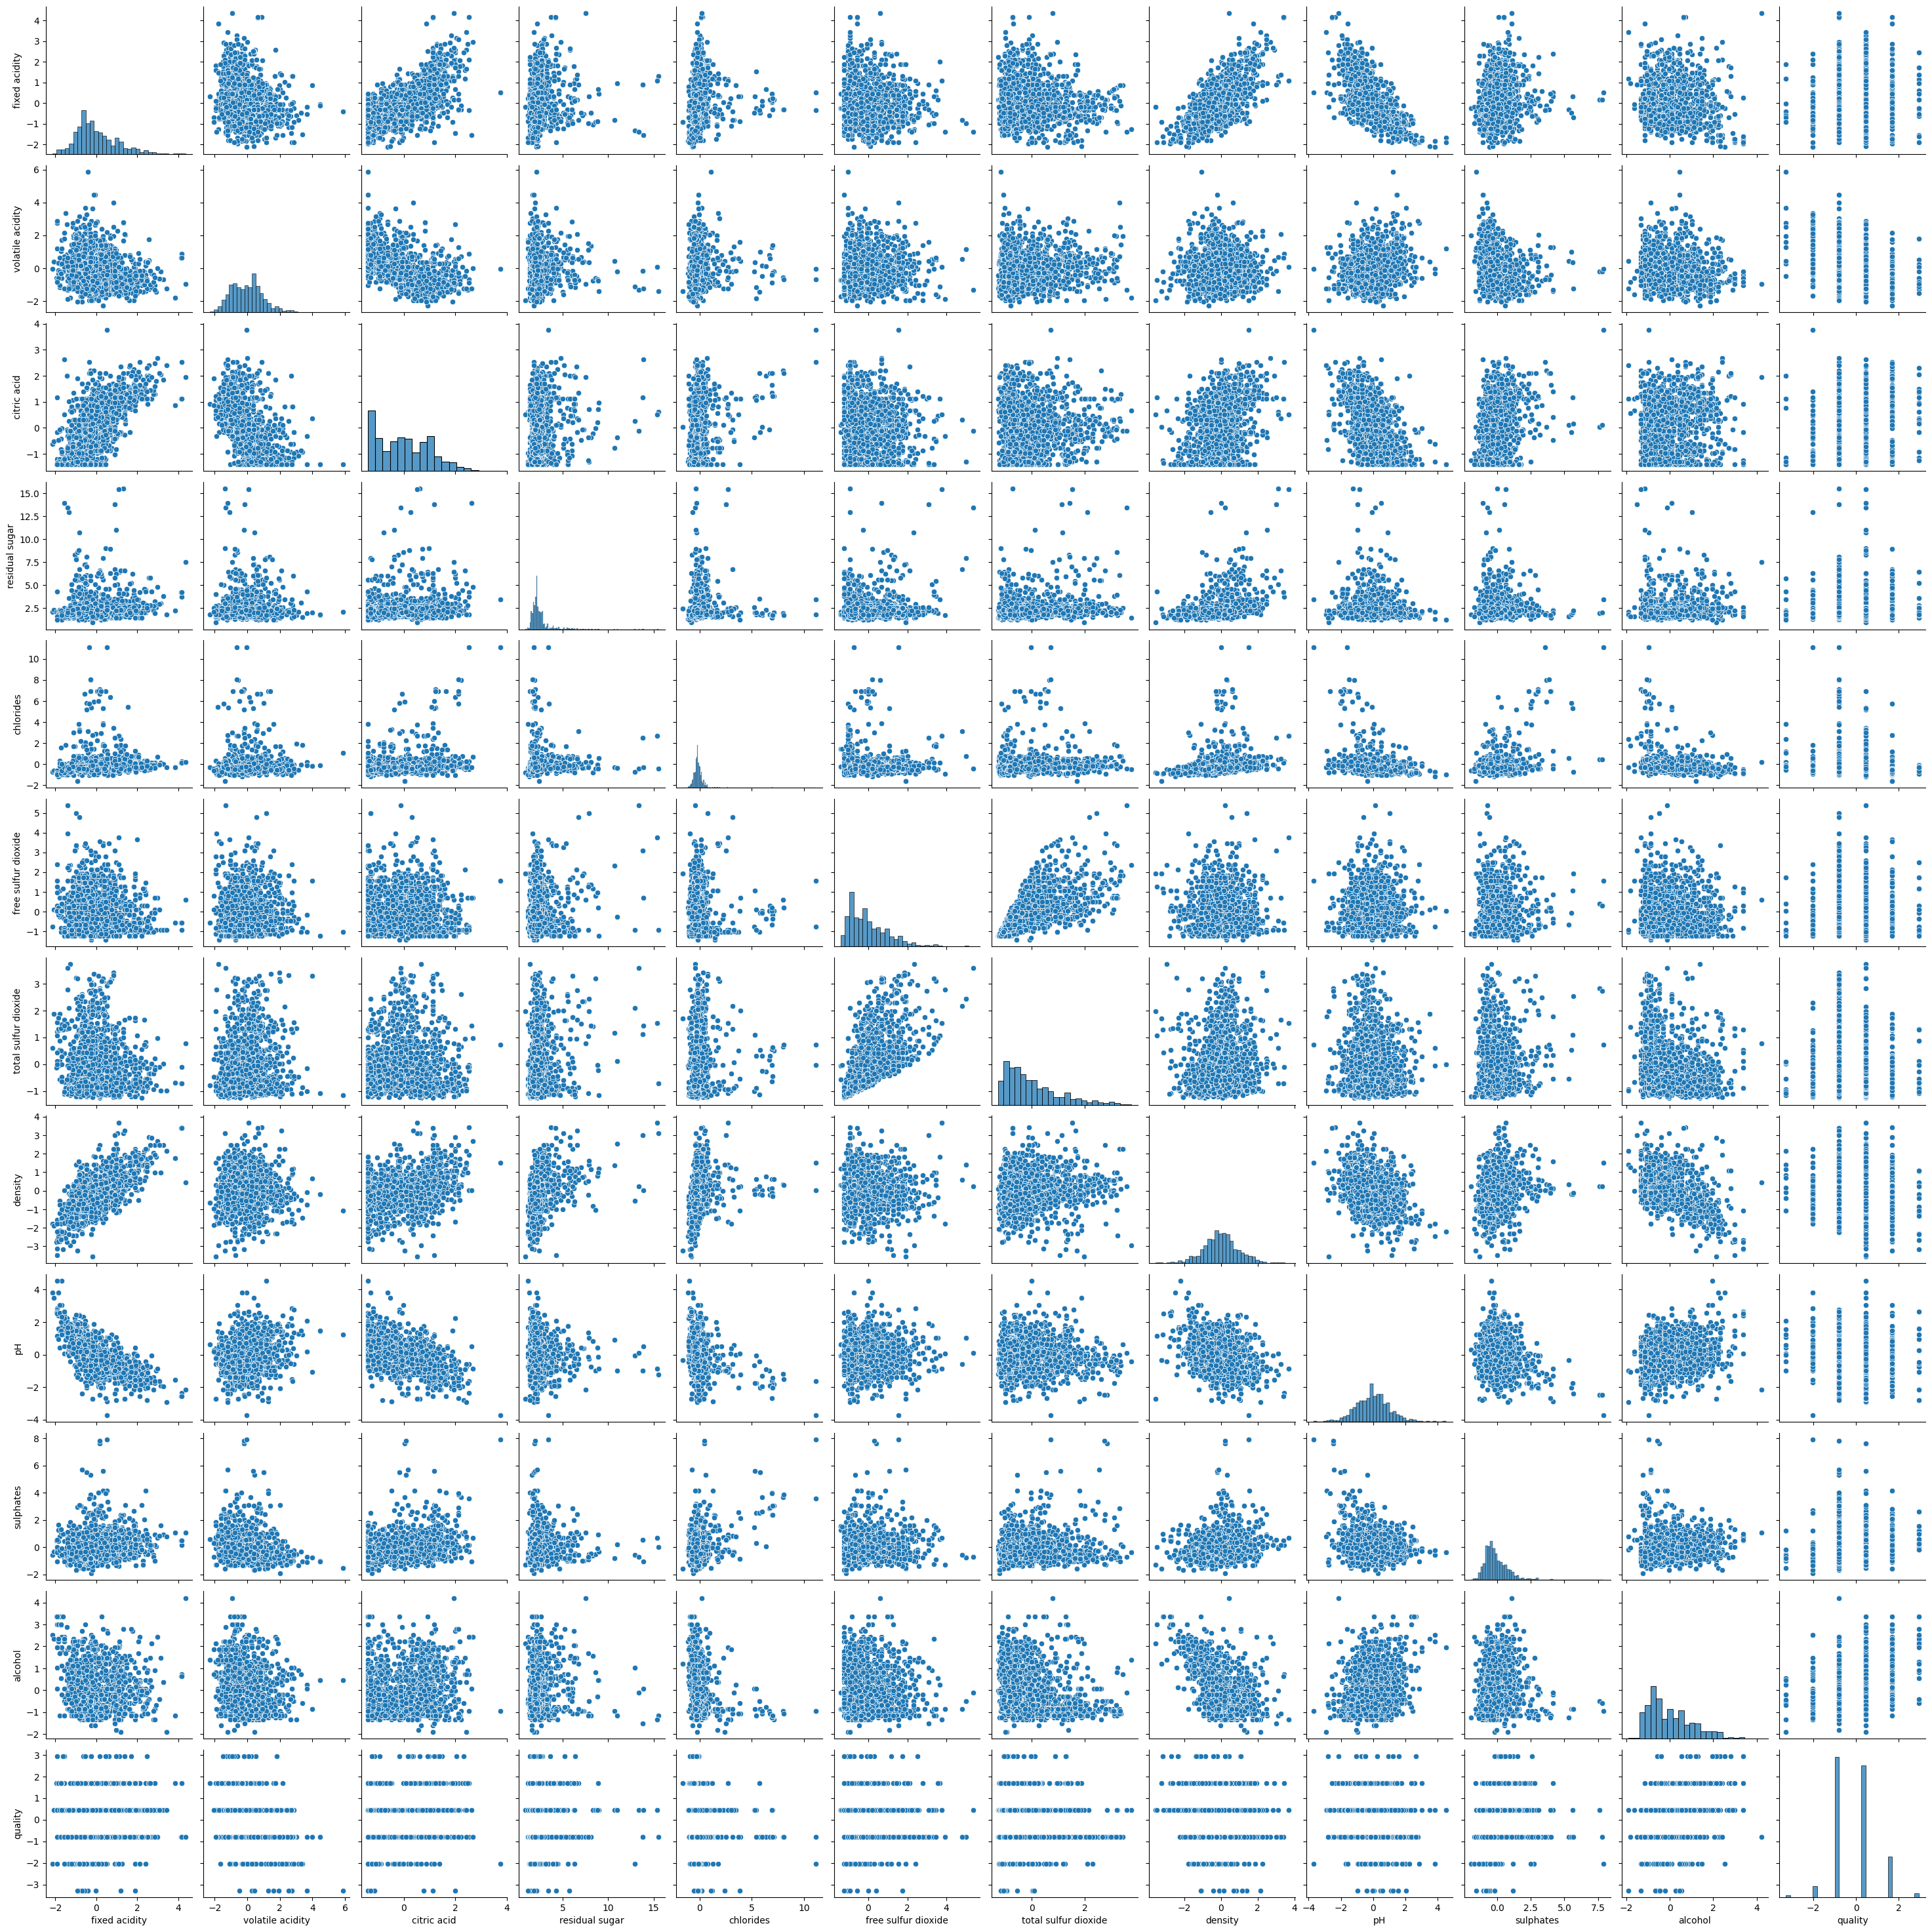

In [78]:
import seaborn as sns

sns.pairplot(data2)